In [18]:
%load_ext autoreload
%autoreload 2

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
from helper_methods import plot_7_class_confusion_matrix,plot_losses,print_7_class_confusion_matrix
from custom_models.mlp import MLP
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [3]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# ?
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz


In [40]:
# set seaborn style
sns.set_theme(context='notebook', style='whitegrid', palette='bright', color_codes=True, rc=None)

### Check dataset balance

In [5]:
import numpy as np
from collections import Counter

# Initialize an empty list to store labels
train_labels = []
test_labels = []
validation_labels = []

# Use a dataloader to extract labels in batches
for _, labels in train_loader_at_eval:
    # Convert numpy arrays to integers before adding to list
    train_labels.extend(labels.cpu().numpy().flatten().tolist())

for _, labels in test_loader:
    test_labels.extend(labels.cpu().numpy().flatten().tolist())
    
for _, labels in validation_loader:
    validation_labels.extend(labels.cpu().numpy().flatten().tolist())
    
# Count the number of occurrences of each label
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
validation_label_counts = Counter(validation_labels)

# Print the counts
print("Train label counts:")
print(train_label_counts)
print("Test label counts:")
print(test_label_counts)
print("Validation label counts:")
print(validation_label_counts)


Train label counts:
Counter({5: 4693, 4: 779, 2: 769, 1: 359, 0: 228, 6: 99, 3: 80})
Test label counts:
Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})
Validation label counts:
Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})


In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


## 1. MLP 

In [7]:
def validation(validation_data, nn, criterion, to_device=True, flatten_input=True):
    if to_device:
        nn = nn.to(device)

    # Validation
    loss = 0

    with torch.no_grad():
        for X_train, y_train in validation_data:

            # send everything to the device (ideally a GPU)
            if to_device:
                X_train = X_train.to(device)
                y_train = y_train.to(device)

            if flatten_input:
                # Flatten RGB images into a single vector
                X_train = X_train.view(X_train.size(0), -1)

            # Remove unused dimension and convert to long
            y_train = y_train.squeeze().long()

            # Forward pass
            outputs = nn(X_train)
            loss += criterion(outputs, y_train).item()

    loss /= len(validation_data)
    return loss

In [8]:
def fit(
    training_data,
    validation_data,
    nn,
    criterion,
    optimizer,
    n_epochs,
    to_device=True,
    flatten_input=True,
):

    # send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)

    # Train the network
    loss_values = {
        "train": [],
        "validation": [],
    }
    for epoch in range(n_epochs):
        accu_loss = 0

        for X_train, y_train in training_data:

            # send everything to the device (ideally a GPU)
            if to_device:
                X_train = X_train.to(device)
                y_train = y_train.to(device)

            if flatten_input:
            # Flatten RGB images into a single vector
                X_train = X_train.view(X_train.size(0), -1)

            # Remove unused dimension and convert to long
            y_train = y_train.squeeze().long()

            # Forward pass
            outputs = nn(X_train)
            loss = criterion(outputs, y_train)
            
            

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accu_loss += loss.item()

        accu_loss /= len(training_data)

        # if (epoch+1) % 10 == 0:
        loss_values["train"].append(accu_loss)

        # Validation
        val_loss = validation(validation_data, nn, criterion, to_device, flatten_input)
        loss_values["validation"].append(val_loss)
        
        # if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {accu_loss}, Validation Loss: {val_loss}")

    return loss_values, nn.to("cpu")

In [9]:
# No of Neurons in Input Layer
input_size = n_channels * train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
# No of Neurons in Hidden Layers
hidden_sizes = [256, 128]
# No of Neurons in Output Layer
num_classes = n_classes

In [10]:
# Create the network, define criterion and optimizer
n_epochs = 10
BATCH_SIZE = 64
n_layers = 5

# Determine the number of classes
hidden_layer_sizes = ((input_size + num_classes) // 2,) * n_layers
mlp = MLP(
    input_size=input_size, hidden_sizes=hidden_layer_sizes, num_classes=num_classes
)

print("Model:")
print(mlp)

# Loss Function
# this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

#criterion = nn.MultiMarginLoss()

# Optimizer
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

mlp_loss_values, mlp = fit(
    training_data=train_loader,
    validation_data=validation_loader,
    nn=mlp,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    to_device=True,
)

Model:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2352, out_features=1179, bias=True)
    (1-4): 4 x Linear(in_features=1179, out_features=1179, bias=True)
    (5): Linear(in_features=1179, out_features=7, bias=True)
  )
  (activations): ModuleList(
    (0-4): 5 x ReLU()
  )
)
Epoch [1/10], Training Loss: 2.1765493176200175, Validation Loss: 2.0372770726680756
Epoch [2/10], Training Loss: 1.9744245214895768, Validation Loss: 2.029297798871994
Epoch [3/10], Training Loss: 1.9193722800775008, Validation Loss: 1.8445139527320862
Epoch [4/10], Training Loss: 1.883279358256947, Validation Loss: 1.9079610109329224
Epoch [5/10], Training Loss: 1.8890333977612581, Validation Loss: 1.8389232009649277
Epoch [6/10], Training Loss: 1.863814891468395, Validation Loss: 1.8225305080413818
Epoch [7/10], Training Loss: 1.8600661223584956, Validation Loss: 1.8715615570545197
Epoch [8/10], Training Loss: 1.844209733876315, Validation Loss: 1.883014589548111
Epoch [9/10], Training Loss: 1.82

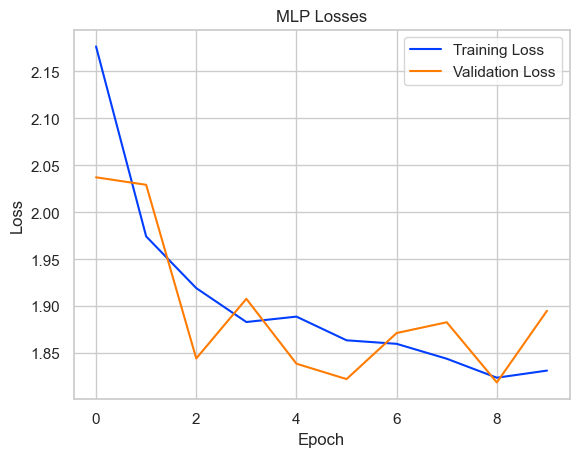

In [41]:
plot_losses(mlp_loss_values, title="MLP Losses")

In [12]:
from sklearn.metrics import confusion_matrix, f1_score


def evaluate_network(nn, test_data, to_device=True, flatten_input = True):
    # Set the model to evaluation mode
    nn.eval()

    if to_device:
        nn = nn.to(device)

    total_samples = len(test_data.dataset)
    correct_sample_predictions = 0
    all_labels = []
    all_preds = []

    # Run the model on the test data
    with torch.no_grad():
        for X, y in test_data:

            if to_device:
                X = X.to(device)
                y = y.to(device)

            if flatten_input:
                # Flatten RGB images into a single vector
                X = X.view(X.size(0), -1)

            # Remove unused dimension and convert to long
            y = y.squeeze().long()

            # Forward pass
            outputs = nn(X)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)

            # Accumulate labels and predictions for confusion matrix and F1 score
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Compute accuracy
            correct_sample_predictions += (predicted == y).sum().item()

    # Compute accuracy
    accuracy = correct_sample_predictions / total_samples

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)

    # Compute F1 score
    f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracy, conf_mat, f1

In [13]:
print('Evaluating with the training data')
accuracy, conf_mat, f1 = evaluate_network(mlp, test_data=train_loader_at_eval, to_device=True)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)


print('Evaluating with the test data')
accuracy, conf_mat, f1 = evaluate_network(mlp, test_data=test_loader, to_device=True)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)


Evaluating with the training data
Accuracy: 0.6697588126159555
F1 Score: 0.11461297058356636
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	0	0	0	0	0	228	0
1	0	0	0	0	0	359	0
2	0	0	0	0	0	769	0
3	0	1	0	0	0	79	0
4	0	0	0	0	0	779	0
5	0	0	0	0	0	4693	0
6	0	0	0	0	0	99	0
Evaluating with the test data
Accuracy: 0.6688279301745635
F1 Score: 0.1145419602818706
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	0	1	0	0	0	65	0
1	0	0	0	0	0	103	0
2	0	0	0	0	0	220	0
3	0	0	0	0	0	23	0
4	0	0	0	0	0	223	0
5	0	0	0	0	0	1341	0
6	0	0	0	0	0	29	0


### 1.1. MLP with Raw Data

### 1.2. MLP with PCA Data

### 1.2. MLP with Extracted Features(?)

### 2.1 CNN 

In [14]:
from torch.functional import F

class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        # Add padding='same' to preserve spatial dimensions
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Calculate the flattened size properly
        # This depends on your input image dimensions
        # For example, if input is 28x28, after two 2x2 pooling layers: 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
cnn = CNN(input_channels=n_channels, num_classes=n_classes)

print("Model:")
print(cnn)

# Loss Function
# this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.RMSprop(cnn.parameters(), lr=0.001)

cnn_loss_values, cnn = fit(
    training_data=train_loader,
    validation_data=validation_loader,
    flatten_input=False,
    nn=cnn,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    to_device=True,
)



Model:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)
Epoch [1/10], Training Loss: 1.0993348560549996, Validation Loss: 0.9226751625537872
Epoch [2/10], Training Loss: 0.9055921169844541, Validation Loss: 0.9134945571422577
Epoch [3/10], Training Loss: 0.8679699323394082, Validation Loss: 0.8477069288492203
Epoch [4/10], Training Loss: 0.8301541377197612, Validation Loss: 0.8941843211650848
Epoch [5/10], Training Loss: 0.7974192034114491, Validation Loss: 0.7624680921435356
Epoch [6/10], Training Loss: 0.7647889370268042, Validation Loss: 0.9008680880069733
Epoch [7/10], Training Loss: 0.744173819639466, Validation Loss: 0.7545155584812164
Epoch [8/10], Training Loss: 0.

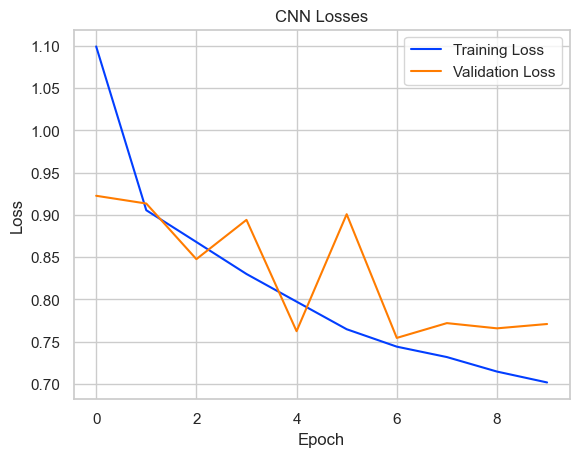

In [42]:
# Plot the loss values over time
plot_losses(cnn_loss_values, title="CNN Losses")

c:\Users\josem\uc\aca\ml-dermatology-project\helper_methods.py:18: SyntaxWarning: invalid escape sequence '\P'
  for i in range(7):


Evaluating with the training data
Accuracy: 0.7329813044098759
F1 Score: 0.3999021003561598
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	18	142	22	0	0	46	0
1	2	294	12	0	1	49	1
2	7	118	319	0	2	320	3
3	0	59	7	0	0	13	1
4	6	46	93	0	41	589	4
5	5	135	139	0	9	4399	6
6	0	20	0	0	0	14	65


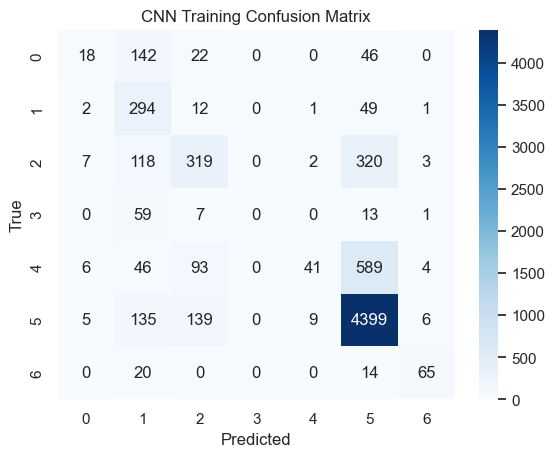

Evaluating with the test data
Accuracy: 0.7117206982543641
F1 Score: 0.3424466880928647
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	6	43	6	0	0	10	1
1	1	82	5	0	0	12	3
2	3	43	82	0	1	91	0
3	0	17	1	0	0	5	0
4	1	18	25	0	8	168	3
5	1	50	48	0	1	1238	3
6	0	9	0	0	1	8	11


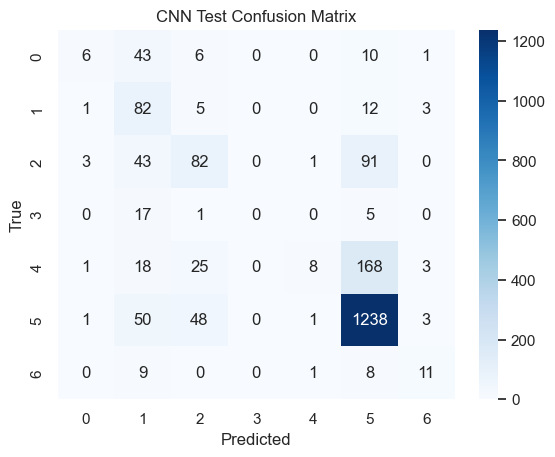

In [45]:
print("Evaluating with the training data")
accuracy, conf_mat, f1 = evaluate_network(
    cnn, test_data=train_loader_at_eval, to_device=True, flatten_input=False
)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)
plot_7_class_confusion_matrix(conf_mat, title="CNN Training Confusion Matrix")

print("Evaluating with the test data")
accuracy, conf_mat, f1 = evaluate_network(
    cnn, test_data=test_loader, to_device=True, flatten_input=False
)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)
plot_7_class_confusion_matrix(conf_mat, title="CNN Test Confusion Matrix")